# Balanced random forest model with balanced accuracy

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

## Some variables

In [2]:
datapath = '/data/ml_course/05_Capstone_project/rf_data/'
model_name = 'balanced_RF_balanced_accuracy.pickle'

In [3]:
# suppress anoying iypthon warnings. Not ideal since we suppress also potentially relevant warnings
#import warnings
#warnings.filterwarnings('ignore')

## Load data

In [4]:
years = ['2018', '2019', '2020']
months = ['04', '05', '06', '07', '08', '09']

for year in years:
    for month in months:
        print(year+month, end="\r", flush=True)
        fname = datapath+year+month+'_data.npz'
        if not os.path.isfile(fname):
            continue
        
        X = None
        with np.load(fname, allow_pickle=False) as npz_file:
            # Load the arrays
            if X is None:
                X = npz_file['features']
                y = npz_file['targets']
            else:
                X = np.concatenate((X, npz_file['features']), axis=0)
                y = np.concatenate((y, npz_file['targets']), axis=0)

In [5]:
print('features matrix shape:', X.shape)
print('target matrix shape:', y.shape)

features matrix shape: (7435724, 6)
target matrix shape: (7435724,)


In [6]:
# Remove NaNs
# NaNs can appear in texture fields.
# They could safely be considered 0s but we remove them
ind_row, ind_col = np.where(np.isnan(X))
X = np.delete(X, ind_row, axis=0)
y = np.delete(y, ind_row, axis=0)

In [7]:
print('features matrix shape:', X.shape)
print('target matrix shape:', y.shape)

features matrix shape: (7432290, 6)
target matrix shape: (7432290,)


In [8]:
# Group together 0 (No POH was computed) and 1 (POH below 90%)
np.unique(y)
y[y == 1] = 0
y[y == 2] = 1
np.unique(y)

array([0, 1], dtype=int8)

In [9]:
npixels = y.size
npixels_hail = y[y==1].size

print('npixels:', npixels)
print('npixels with hail:', npixels_hail)
print('% of pixels with hail:', npixels_hail/npixels*100)

npixels: 7432290
npixels with hail: 61171
% of pixels with hail: 0.8230437725115678


## Split data into test and training

In [10]:
# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.99, random_state=0)

In [11]:
print('features matrix for training shape:', X_tr.shape)
print('target matrix for training shape:', y_tr.shape)

features matrix for training shape: (74322, 6)
target matrix for training shape: (74322,)


## Prepare data folds

In [12]:
ss = ShuffleSplit(n_splits=3, test_size=0.10, random_state=0)
ss.get_n_splits()

3

## Random Forest

In [13]:
# Create pipeline
# Balanced random forest
pipe_RF = Pipeline([
    ('scaler', None),
    ('RF', BalancedRandomForestClassifier(random_state=0, max_depth=None))
])

# Create cross-validation object
n_estimators = np.r_[np.arange(1, 22, 2), np.arange(20, 60, 10)]
#n_estimators = np.array([20])
grid_RF = {'RF__n_estimators': n_estimators}

grid_RF_cv = GridSearchCV(pipe_RF, grid_RF, scoring='balanced_accuracy', cv=ss, return_train_score=True, verbose=True, n_jobs=-1)

# Fit estimator
grid_RF_cv.fit(X_tr, y_tr)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.1, train_size=None),
             estimator=Pipeline(steps=[('scaler', None),
                                       ('RF',
                                        BalancedRandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'RF__n_estimators': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 20, 30, 40, 50])},
             return_train_score=True, scoring='balanced_accuracy',
             verbose=True)

## Evaluate model

In [14]:
# Collect results in a DataFrame
RF_results = pd.DataFrame({
    'trees': grid_RF_cv.cv_results_['param_RF__n_estimators'],
    'mean_tr': grid_RF_cv.cv_results_['mean_train_score'],
    'mean_te': grid_RF_cv.cv_results_['mean_test_score'],
    'std_te': grid_RF_cv.cv_results_['std_test_score']
})

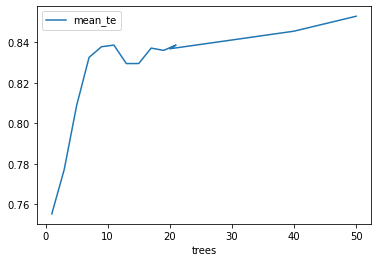

In [15]:
# Plot test curve
RF_results.plot(x='trees', y='mean_te')
plt.show()

In [16]:
# Ten best combinations according to the mean test score
RF_results.sort_values(by='mean_te', ascending=False).head(10)

,trees,mean_tr,mean_te,std_te
14,50,0.909411,0.852936,0.010133
13,40,0.909659,0.845555,0.012164
12,30,0.909602,0.841195,0.015056
5,11,0.901760,0.838674,0.022018
10,21,0.903396,0.838672,0.018264
4,9,0.900390,0.837862,0.012238
8,17,0.903436,0.837187,0.016852
11,20,0.908663,0.836857,0.022856
9,19,0.903208,0.836056,0.016460
3,7,0.899574,0.832587,0.011519


In [17]:
# Report test score
acc_RF = 100*grid_RF_cv.score(X_te, y_te)
print('Test accuracy: {:.2f}%'.format(acc_RF))

Test accuracy: 84.82%


In [18]:
y_pred = grid_RF_cv.predict(X_te)

In [19]:
tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

In [20]:
print('True positive: ', tp)
print('True negative: ', tn)
print('False positive: ', fp)
print('False negative: ', fn)
print('Positive pixels: ', y_te[y_te == 1].size)
print('Negative pixels: ', y_te[y_te == 0].size)

True positive:  53111
True negative:  5978153
False positive:  1319264
False negative:  7440
Positive pixels:  60551
Negative pixels:  7297417


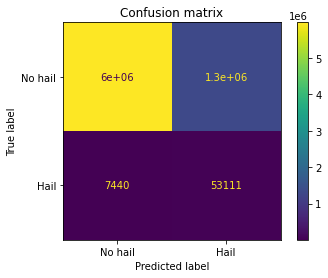

In [21]:
disp = plot_confusion_matrix(grid_RF_cv, X_te, y_te, labels=[0, 1], display_labels=['No hail', 'Hail'], normalize=None)
disp.ax_.set_title('Confusion matrix')
plt.show()

In [22]:
pod = 100*tp/(tp+fn)
far = 100*fp/(fp+tn)
ppv = tp/(tp+fp)
print('Probability of Detection (POD):', pod)
print('False Alarm Rate (FAR):', far)
print('Positive Predictive Value (PPV):', ppv)

Probability of Detection (POD): 87.71283711251672
False Alarm Rate (FAR): 18.07850640850043
Positive Predictive Value (PPV): 0.03870006375808362


## Save best model

In [23]:
with open(model_name, 'wb') as bfile: 
    s = pickle.dump(grid_RF_cv.best_estimator_, bfile)

In [24]:
with open(model_name, 'rb') as bfile:
    rf_model_best = pickle.load(bfile)

## Get features importance

In [25]:
features = ['HRV_norm', 'HRV_norm_text', 'IR_108', 'IR_108_text', 'WV_062-IR_108', 'WV_062-IR_108_text']
f_importance = rf_model_best['RF'].feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_best['RF'].estimators_], axis=0)
inds = np.argsort(f_importance)[::-1]
f_importance_ordered = f_importance[inds]
features_ordered = np.array(features)[inds]

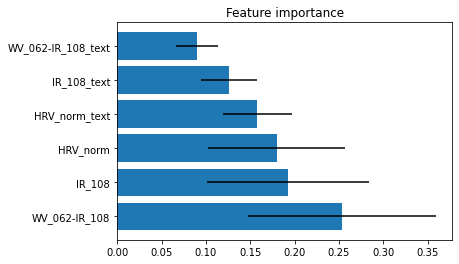

In [26]:
plt.barh(np.arange(6), f_importance_ordered, xerr=std[inds], align="center")
plt.yticks(np.arange(6), features_ordered)
plt.title('Feature importance')
plt.show()